# Predicción de series temporales con modelos básicos de Deep Learning (LSTM)

En el siguiente noebook se detalla el proceso de entrenamiento de una red neuronal con modelos de LSTM. Codigo basado en https://github.com/gianfelton

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt                       
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

### Importación de datos

In [3]:
df = pd.read_csv('monthly-beer-production-in-austr.csv')

In [4]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [6]:
df.Month = pd.to_datetime(df.Month)

In [7]:
df = df.set_index("Month")
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [8]:
df.index.freq = 'MS'

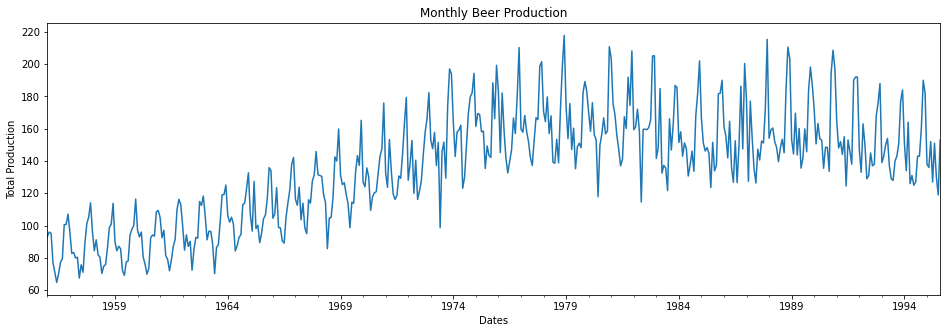

In [9]:
ax = df['Monthly beer production'].plot(figsize = (16,5), title = "Monthly Beer Production")
ax.set(xlabel='Dates', ylabel='Total Production');

## Entrenamiento de modelo de LSTM

#### Pre-procesamiento de datos con MinMaxScaler

In [10]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Antes de crear el modelo LSTM, debemos crear un objeto Generador de series temporales.

In [13]:
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12 # El nombre de dades que s'utilitzen per fer la prediccio. 12 mesos dades, + 1 de prediccio?
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, 
                                length=n_input, batch_size=1)

### Modelo básico de LSTM

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')


lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [16]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
452/452 [==============================] - 3s 4ms/step - loss: 0.0244
Epoch 2/20
452/452 [==============================] - 2s 4ms/step - loss: 0.0147
Epoch 3/20
452/452 [==============================] - 2s 4ms/step - loss: 0.0126
Epoch 4/20
452/452 [==============================] - 2s 4ms/step - loss: 0.0112
Epoch 5/20
452/452 [==============================] - 2s 4ms/step - loss: 0.0098
Epoch 6/20
452/452 [==============================] - 2s 4ms/step - loss: 0.0084
Epoch 7/20
452/452 [==============================] - 2s 4ms/step - loss: 0.0084
Epoch 8/20
452/452 [==============================] - 2s 4ms/step - loss: 0.0069
Epoch 9/20
452/452 [==============================] - 2s 4ms/step - loss: 0.0078
Epoch 10/20
452/452 [==============================] - 2s 5ms/step - loss: 0.0074
Epoch 11/20
452/452 [==============================] - 2s 4ms/step - loss: 0.0074
Epoch 12/20
452/452 [==============================] - 2s 5ms/step - loss: 0.0078
Epoch 13/20
452/452 [====

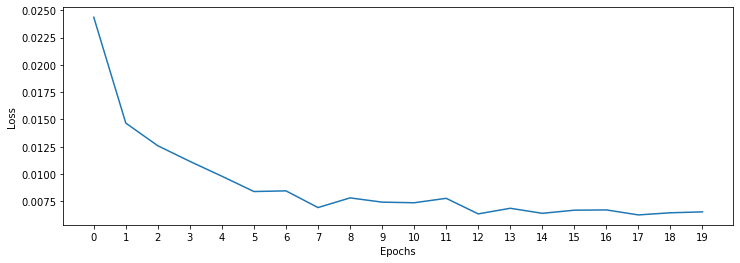

In [17]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

## Predicción sobre datos de test

A continuación vamos a realizar una predicción para 12 meses (12 predicciones). Para ello vamos a hacer los siguiente:
- crear una lista vacía para cada una de nuestras 12 predicciones
- crear el lote que nuestro modelo predecirá 
- guardar la predicción en nuestra lista
- agregar la predicción al final del lote para usarla en la próxima predicción

In [18]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]

In [21]:
current_batch = batch.reshape((1, n_input, n_features))

In [22]:
current_batch

array([[[0.51111111],
        [0.56339869],
        [0.73333333],
        [0.77908497],
        [0.56339869],
        [0.45228758],
        [0.64836601],
        [0.4       ],
        [0.43267974],
        [0.39346405],
        [0.40653595],
        [0.51111111]]])

In [23]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 16ms/step


Como saben, escalamos nuestros datos, por eso tenemos que invertirlos para ver predicciones verdaderas.

In [24]:
lstm_predictions_scaled

[array([0.58368933], dtype=float32),
 array([0.68693256], dtype=float32),
 array([0.82382023], dtype=float32),
 array([0.826057], dtype=float32),
 array([0.64339554], dtype=float32),
 array([0.613906], dtype=float32),
 array([0.6644756], dtype=float32),
 array([0.5187595], dtype=float32),
 array([0.5120217], dtype=float32),
 array([0.4873429], dtype=float32),
 array([0.5071957], dtype=float32),
 array([0.5762366], dtype=float32)]

In [25]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [26]:
lstm_predictions

array([[154.1044678 ],
       [169.90068226],
       [190.8444957 ],
       [191.18672358],
       [163.23951809],
       [158.72762196],
       [166.46476983],
       [144.17020183],
       [143.13932322],
       [139.36346279],
       [142.4009438 ],
       [152.96420066]])

In [27]:
test_data['LSTM_Predictions'] = lstm_predictions

In [28]:
test_data

,Monthly beer production,LSTM_Predictions
Month,,
1994-09-01,143.0,154.104468
1994-10-01,160.0,169.900682
1994-11-01,190.0,190.844496
1994-12-01,182.0,191.186724
1995-01-01,138.0,163.239518
1995-02-01,136.0,158.727622
1995-03-01,152.0,166.464770
1995-04-01,127.0,144.170202
1995-05-01,151.0,143.139323


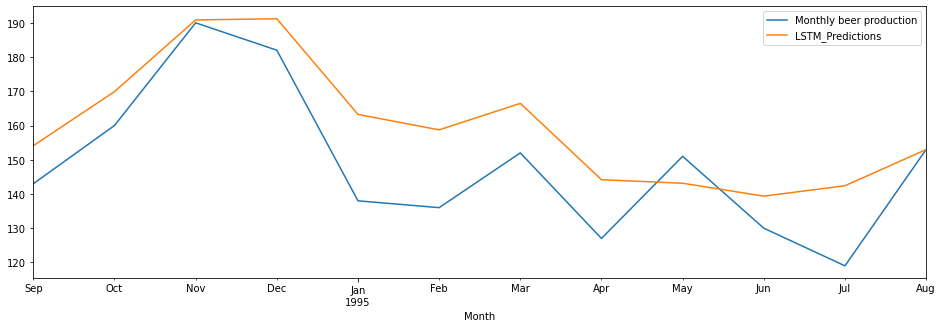

In [29]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [30]:
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 221.76128127221975
RMSE Error: 14.891651395067631
Mean: 136.39537815126045
